# Answering Data Science questions on Stack Exchange

Stack Exchange is a platform on which users can ask questions related to data science and receive answers from other users. The general trend I have noticed is that students and those new to data science tend to be the ones asking the questions, and experts in the field answer them. However even experienced data scientists can ask questions and draw on each other's knowledge to help solve problems. In this project I will aim to find the most popular types of content on Stack Exchange. In order to do this I will need to define what exactly "popular" means when it comes to posts. I notice there are 3 types of numerical data associated with each question: answers, votes, and views. The views will always be the highest number. I will use these 3 types of data as my basis for defining popularity.

The dataset contains a large number of tables, so I will have to narrow down which ones are the most useful for my purposes. The "tags" and "posts" tables look particularly promising towards discovering the most popular content on Stack Exchange. "Posts" contains data regarding the view count (although not for every post) as well as the answer count, comment count, and included tags. The "VoteTypes" table looks intriguing as well as it categorizes votes and distinguishes between up-votes and down-votes. Having a high number of votes doesn't guarantee the post is popular!

I will start by filtering the data in SQL to only questions and answers posted in 2022, as my focus will be on recent posts:

#### SELECT * FROM posts WHERE year(CreationDate)=2022;

I will now read a Stack Exchange file into a dataframe and explore some attributes of the data. The first thing I will examine is how many missing values are contained in each column.

In [1]:
import pandas as pd
questions=pd.read_csv("2019_questions.csv")
#questions=pd.read_csv("C://Downloads/QueryResults.csv")
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [2]:
questions.columns

Index(['Id', 'CreationDate', 'Score', 'ViewCount', 'Tags', 'AnswerCount',
       'FavoriteCount'],
      dtype='object')

In [3]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null object
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 483.5+ KB


In [4]:
for column in questions.columns:
    print(column +' has ' +str(questions[column].isna().sum())+' null values')  

Id has 0 null values
CreationDate has 0 null values
Score has 0 null values
ViewCount has 0 null values
Tags has 0 null values
AnswerCount has 0 null values
FavoriteCount has 7432 null values


In [5]:
print(len(questions))

8839


Only one column contains any null values: "FavoriteCount". The vast majority of rows have missing values in this column (7432 out of 8839). Therefore I don't want to get rid of these rows completely, as we will lose a lot of valuable data. After researching the issue I found that the reason these questions have missing values is that they were never favorited, whereas questions that have 0 favorites were favorited at some point but later removed. I will change the values of the questions with missing values to 0. Before I do this however I will also add a Boolean column indicating whether the question has ever been favorited.

In [6]:
questions['Has Been Favorited']=True
questions.loc[questions['FavoriteCount'].isnull(), 'Has Been Favorited']=False
questions.loc[questions['FavoriteCount'].isnull(), 'FavoriteCount']=0
questions.head(5)


,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount,Has Been Favorited
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,0.0,False
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,0.0,False
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,0.0,False
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,0.0,False
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,0.0,False


I will change the CreationDate column to be datetime objects rather than strings, so that I can perform operations on it. I will also convert the FavoriteCount column to integer format rather than float. 

In [7]:
questions['CreationDate']=pd.to_datetime(questions['CreationDate'])
questions["FavoriteCount"]=questions["FavoriteCount"].astype(int)

In [8]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 8 columns):
Id                    8839 non-null int64
CreationDate          8839 non-null datetime64[ns]
Score                 8839 non-null int64
ViewCount             8839 non-null int64
Tags                  8839 non-null object
AnswerCount           8839 non-null int64
FavoriteCount         8839 non-null int64
Has Been Favorited    8839 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(5), object(1)
memory usage: 492.1+ KB


Now that the data no longer contains missing values, I will clean up the "Tags" column. Note a sample value from "Tags":

In [9]:
questions["Tags"][1]

'<machine-learning><regression><linear-regression><regularization>'

I will replace the "<" and ">" signs with commas.

In [10]:
questions["Tags"]=questions["Tags"].str.replace("><", ",").str.replace(">", "").str.replace("<", "")
questions["Tags"][1]

'machine-learning,regression,linear-regression,regularization'

I will also split the values into list form:

In [11]:
questions["Tags"]=questions["Tags"].str.split(",")
questions["Tags"][1]

['machine-learning', 'regression', 'linear-regression', 'regularization']

My next step will be to determine the most popular tags that appear in questions. I will do so by counting how many times a particular tag was used, as well as by counting how many times a question containing that tag was viewed. I will create a new dataframe called 'tag_data' containing this information. First I will create separate dataframes containing the number of appearances and the number of views for each tag, and then I will join them together.

In [12]:
def tag_counter(tag):
    counter=0
    for row in questions["Tags"]:
        counter+=row.count(tag)
    return counter

In [13]:
unique_tags=[]
for row in questions["Tags"]:
    for item in row:
        if item not in unique_tags:
            unique_tags.append(item)

In [14]:
appearance_list=[]
for i in unique_tags:
    appearance_list.append(tag_counter(i))
    

datas={'tag': unique_tags, 'appearances': appearance_list}
tag_appearances=pd.DataFrame(data=datas)

In [15]:
tag_appearances.head()

,appearances,tag
0,2693,machine-learning
1,217,data-mining
2,347,regression
3,175,linear-regression
4,50,regularization


c

In [16]:
tags_dictionary={}
for item in unique_tags:
    tags_dictionary[item]=0

In [17]:
counter=-1
for item in questions["Tags"]:
    counter+=1
    view_counts=questions["ViewCount"].iloc[counter]
    for tag in item:
        counts=tags_dictionary[tag]
        counts+=view_counts
        tags_dictionary[tag]=counts


In [18]:
tag_views = pd.DataFrame(data={'tag': list(tags_dictionary.keys()), 'views': list(tags_dictionary.values())})
tag_views.head()


,tag,views
0,interpolation,767
1,imbalanced-learn,3183
2,sequence-to-sequence,10523
3,manifold,80
4,hurdle-model,12


I now have two new dataframes: one which displays the number of times each tag was used and the other which displays the number of times each tag was viewed. I will join these two dataframes together.

In [19]:
tag_data=tag_appearances.merge(tag_views, how="inner", on="tag")
tag_data=tag_data[['tag', 'appearances', 'views']]
tag_data.head()

,tag,appearances,views
0,machine-learning,2693,388499
1,data-mining,217,31056
2,regression,347,49451
3,linear-regression,175,18978
4,regularization,50,4941


I can use this dataframe to create visualizations for the tags with the most appearances and views.

In [20]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [21]:
sorted_by_views=tag_data.sort_values(by='views', ascending=False)
sorted_by_appearances=tag_data.sort_values(by='appearances', ascending=False)

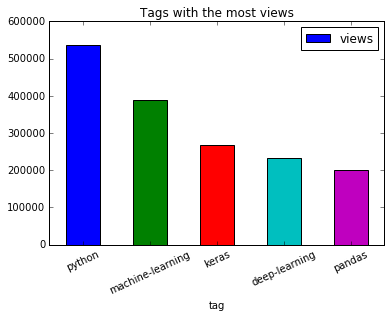

In [22]:
sorted_by_views.head().plot(x="tag", y="views", kind="bar", rot=25)
plt.title("Tags with the most views")
plt.show()

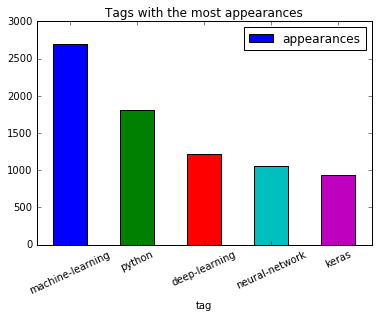

In [23]:
sorted_by_appearances.head().plot(x="tag", y="appearances", kind="bar", rot=25)
plt.title("Tags with the most appearances")
plt.show()

I will also check to make sure there are no missing values in the data:

In [24]:
tag_data[tag_data.isnull()==True].count()

tag            0
appearances    0
views          0
dtype: int64

We can clearly see that four tags- "python", "machine learning", "deep learning" and "keras" appear both in the top 5 for views and appearances. Thus it is safe to say these are the most popular tags. However I would like to find more than 4 popular tags, so I will join together the 20 tags with the most views and the 20 tags with the most appearances to see what other tags appear in both.

In [25]:
popular_tags=sorted_by_views.head(20).merge(sorted_by_appearances.head(20), how="inner", on="tag")

In [26]:
popular_tags["views"]=popular_tags["views_x"]
popular_tags["appearances"]=popular_tags["appearances_x"]
popular_tags=popular_tags[["tag", "appearances", "views"]]
popular_tags

,tag,appearances,views
0,python,1814,537585
1,machine-learning,2693,388499
2,keras,935,268608
3,deep-learning,1220,233628
4,pandas,354,201787
5,neural-network,1055,185367
6,scikit-learn,540,128110
7,tensorflow,584,121369
8,classification,685,104457
9,lstm,402,74458


I now have 16 tags which appear in the top 20 for both views and appearances. There is no perfect way to empirically define popularity, but I will give each tag a "popularity score" but multiplying the number of appearances by the number of views for each tag.

In [27]:
popular_tags["popularity score"]=popular_tags["views"]*popular_tags["appearances"]


Below are the results for the popular tags sorted by highest popularity score to lowest:

In [28]:
popular_tags.sort_values(by='popularity score', ascending=False)

,tag,appearances,views,popularity score
1,machine-learning,2693,388499,1046227807
0,python,1814,537585,975179190
3,deep-learning,1220,233628,285026160
2,keras,935,268608,251148480
5,neural-network,1055,185367,195562185
8,classification,685,104457,71553045
4,pandas,354,201787,71432598
7,tensorflow,584,121369,70879496
6,scikit-learn,540,128110,69179400
10,nlp,493,71382,35191326


"Machine learning" is the most popular tag based on this criterion.

The next step in this project will be examining the relationship between tags, and which tags often appear together. I will create a matrix to store the value for how often each tag appears in a post with each other tag. I will then use this to generate a heatmap showing the correlations between the most common tags.

In [29]:
tag_matrix=pd.DataFrame(index=unique_tags, columns=unique_tags)

In [30]:
tag_matrix=tag_matrix.fillna(0)

In [31]:
for row in questions["Tags"]:
    for item in row:
        for value in row:
            tag_matrix[item][value]+=1
       

In [32]:
popular_tags_list=list(popular_tags["tag"])
filter_1=tag_matrix[tag_matrix.columns.isin(popular_tags_list)]
filter_2=filter_1[popular_tags_list]

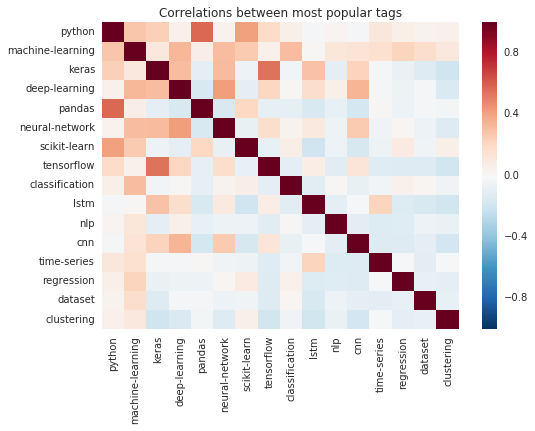

In [33]:
import seaborn as sn
ax=plt.axes()
sn.heatmap(filter_2.corr())
ax.set_title("Correlations between most popular tags")
plt.show()

The two pairs of tags that are most highly correlated together are "python" - "pandas" and "tensorflow" - "keras". This is unsurprising, as pandas is a prominent feature of python and keras is often run on top of tensorflow.

The final step in my project will be to answer the question posed by Dataquest- "Is deep learning just a fad?"

I will examine how the frequency of questions asked about deep learning has changed over time.

In [34]:
all_qs=pd.read_csv("all_questions.csv")
deep_learning_qs=all_qs[all_qs["Tags"].str.contains("deep-learning")]

In [35]:
years=[]
qs_by_year=[]
for year in range(2014, 2021):
    years.append(year)
    qs_by_year.append(len(deep_learning_qs[deep_learning_qs["CreationDate"].str.contains(str(year))]))

In [36]:
years=years[:-1]
qs_by_year=qs_by_year[:-1]

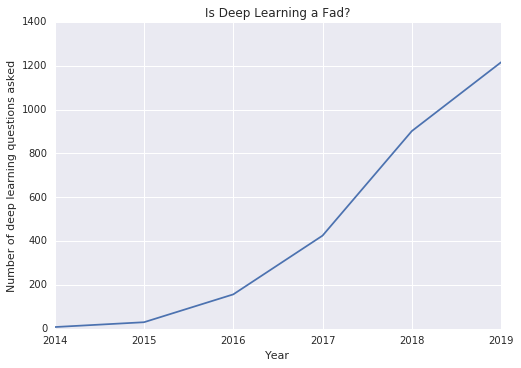

In [37]:
plt.plot(years, qs_by_year)
plt.xlabel("Year")
plt.ylabel("Number of deep learning questions asked")
plt.xticks(years, years)
plt.title("Is Deep Learning a Fad?")
plt.show()


We can observe that the number of questions asked regarding deep learning increased every year between 2014-2019. Thus based on our data we can conclude that deep learning is not in fact a fad, but rather a subject that has steadily gained interest year after year. 